# Household analysis code

This is the methods for the ONS CIS household study https://arxiv.org/abs/2104.04605 applied to open data from:

Lavezzo, E., Franchin, E., Ciavarella, C. et al. Suppression of a SARS-CoV-2 outbreak in the Italian municipality of Vo. Nature 584, 425–429 (2020). https://doi.org/10.1038/s41586-020-2488-1


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.optimize as op
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import pickle
from itertools import combinations

In [2]:
with open("./Y.pickle", "rb") as f:
    Y = pickle.load(f)
with open("./XX.pickle", "rb") as f:
    XX = pickle.load(f)

In [3]:
m = len(Y)

## Histograms

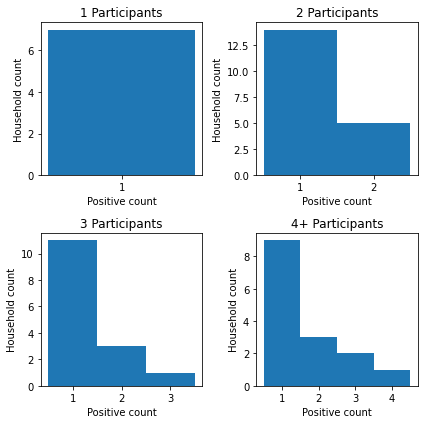

In [4]:
n = np.zeros(m)
y = np.zeros(m)
for i in range(0,m):
    n[i] = len(Y[i])
    y[i] = np.sum(Y[i])
    
plt.figure(figsize=(6,6))

for nn in range(1,4):
    plt.subplot(2,2,nn)
    yy = y[n==nn]
    counts, bins, bars = plt.hist(yy,bins=np.arange(0.5,nn+1.5,1))
    plt.title(str(nn) + ' Participants')
    plt.xlabel('Positive count')
    plt.ylabel('Household count')
    plt.xticks(np.arange(1,nn+1))

plt.subplot(2,2,4)
yy = y[n>=4]
counts, bins, bars = plt.hist(yy,bins=np.arange(0.5,5.5,1))
plt.title('4+ Participants')
plt.xlabel('Positive count')
plt.ylabel('Household count')
plt.tight_layout()

## Density plot

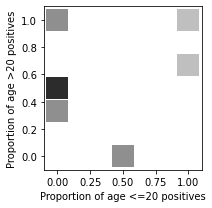

In [5]:
w = []
for i in range(0,m):
    mm = len(Y[i])
    if (np.sum(Y[i]) > 0):
        nkids = np.sum(XX[i])
        nadults = mm-nkids
        npos = np.sum(Y[i])
        nkpos = np.sum(np.sum(XX[i],1)*Y[i])
        napos = npos-nkpos
        if (nadults>0) and (nkids>0):
            w.append([nkpos/nkids,napos/nadults])
ww = np.array(w)

plt.figure(figsize=(3,3))
plt.scatter(ww[:,0],ww[:,1],marker='s',s=500,alpha=0.25,linewidths=0,c='k')
plt.xlabel('Proportion of age <=20 positives')
plt.ylabel('Proportion of age >20 positives')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.tight_layout()

## Pair and Residual Plots

These are done by age: Negative; Young positives; Old positives.


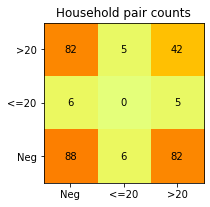

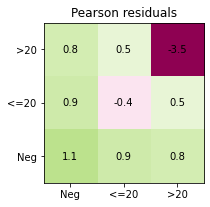

In [6]:
y = np.zeros((3,3))
z = np.zeros((3))

na = []

for i in range(0,len(Y)):
    if (np.sum(Y[i]) > 0):
        na.append(len(Y[i]))
        xx = np.zeros(len(Y[i]))
        for k in range(0,len(Y[i])):
            if (Y[i][k] > 0):
                if (XX[i][k][0] == 1):
                    xx[k] = 1
                else:
                    xx[k] = 2

        for comb in combinations(range(0,len(xx)),2):
            y[int(xx[comb[0]]),int(xx[comb[1]])] += 1
            y[int(xx[comb[1]]),int(xx[comb[0]])] += 1
        for x in xx:
            z[int(x)] += 1

n = np.sum(z)
na = np.array(na)
e = np.outer(z,z)*np.sum(na*(na-1))/(n**2)
r = (y-e)/np.sqrt(e)

plt.figure(figsize=(3,3))
plt.imshow(y,origin='lower')
plt.xticks([0,1,2],['Neg','<=20','>20'])
plt.yticks([0,1,2],['Neg','<=20','>20'])
for (jj,ii),label in np.ndenumerate(y):
    plt.text(ii,jj,str(int(label)),ha='center',va='center')
plt.title('Household pair counts')
plt.set_cmap('Wistia')
plt.tight_layout()

plt.figure(figsize=(3,3))
plt.imshow(r,origin='lower',vmin=-3,vmax=3)
plt.xticks([0,1,2],['Neg','<=20','>20'])
plt.yticks([0,1,2],['Neg','<=20','>20'])
for (jj,ii),label in np.ndenumerate(r):
    plt.text(ii,jj,str(0.1*int(label*10)),ha='center',va='center')
plt.title('Pearson residuals')
plt.set_cmap('PiYG')
plt.tight_layout()

## Regression Model

In [7]:
# Utility function for converting between decimal and bit array

def decimal_to_bit_array(d, n_digits):
    powers_of_two = int(2) ** np.arange(32)[::-1]
    return ((d & powers_of_two) / powers_of_two)[-n_digits:]

In [8]:
# Laplace transform of the infectious time distribution 

def phi(s, logtheta=0.0):
    theta = np.exp(logtheta)
    return (1.0 + theta * s) ** (-1.0 / theta)

In [9]:
# Main function for returning negative log likelihood + negative log prior

def mynll(x):
    llaL = x[0]
    llaG = x[1]
    logtheta = x[2]
    eta = (4.0 / np.pi) * np.arctan(x[3])
    alpha = np.array([x[3]])
    beta = np.array([x[4]])
    gamma = np.array([x[5]])

    hhnums = len(Y)
    nlv = np.zeros(hhnums)  # Vector of negative log likelihoods
    for i in range(0, hhnums):
        y = Y[i]
        X = XX[i]
        if np.all(y == 0):
            nlv[i] = np.exp(llaG) * np.sum(np.exp(alpha @ (X.T)))
        else:
            # Sort to go zeros then ones
            ii = np.argsort(y)
            y = y[ii]
            X = X[ii, :]
            q = np.sum(y > 0)
            r = 2 ** q
            m = len(y)

            # Quantities that don't vary through the sum
            Bk = np.exp(-np.exp(llaG) * np.exp(alpha @ (X.T)))
            laM = (
                np.exp(llaL)
                * np.outer(np.exp(beta @ (X.T)), np.exp(gamma @ (X.T)))
                * (m ** eta)
            )

            BB = np.zeros((r, r))  # To be the Ball matrix
            for jd in range(0, r):
                j = decimal_to_bit_array(jd, m)
                for omd in range(0, jd + 1):
                    om = decimal_to_bit_array(omd, m)
                    if np.all(om <= j):
                        my_phi = phi((1 - j) @ laM, logtheta)

                        # Catch any problems and return an Inf if failure
                        if np.any(
                            np.floor(np.log10(np.abs(my_phi[my_phi != 0]))) < -100
                        ):
                            return np.inf

                        BB[jd, omd] = 1.0 / np.prod(
                            (my_phi ** om) * (Bk ** (1 - j))
                        )
            if np.any(np.isnan(BB)) or np.any(np.isinf(BB)):
                return np.inf
            nlv[i] = -np.log(LA.solve(BB, np.ones(r))[-1])
    nll = np.sum(nlv)

    # Standard normal prior
    nll += 1.0 * np.sum(x ** 2)
    
    return nll


In [10]:
# Make one start at zero and others randomly within bounds
x0 = np.array([
    -1.0,
    -3.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
])
mynll(x0)

355.0515106487094

In [11]:
# These bounds are different for these data than the CIS study
bb = np.array([
    [-2.,0.],
    [-4.,-2.],
    [-10.,10.],
    [-10.,10.],
    [-3.,3.],
    [-3.,3.],
    [-3.,3.],
])

In [12]:
# First start at the origin
foutstore = []
fout = op.minimize(mynll,x0,method='TNC',bounds=bb,options={'maxiter' : 10000})
foutstore.append(fout)

In [ ]:
# Because box bounded and complex problem, use multiple restarts

np.random.seed(31)
nrestarts = 19
for k in tqdm(range(0,nrestarts)):
    nll0 = np.nan
    while ((np.isnan(nll0)) or (np.isinf(nll0))):
        xx0 = np.random.uniform(bb[:,0],bb[:,1])
        nll0 = mynll(xx0)
    try:
        fout = op.minimize(mynll,xx0,bounds=bb,method='TNC',options={'maxiter' : 10000})
        foutstore.append(fout)
    except:
        k -= 1

In [15]:
ff = np.inf*np.ones(nrestarts+1)
for i in range(0,len(foutstore)):
    if (foutstore[i].success) and np.all(foutstore[i].x > bb[:,0]) and np.all(foutstore[i].x < bb[:,1]): 
        # This checks for a successful interior optimisation
        ff[i] = foutstore[i].fun
xhat = foutstore[ff.argmin()].x
print(xhat)

[-2.79904682e-01 -3.67972247e+00  1.83082033e-02 -1.05671226e+00
 -3.24974803e-01 -4.35358254e-02 -2.12545508e-04]


In [16]:
pn = len(x0)
delta = 1e-2
dx = delta*xhat
ej = np.zeros(pn)
ek = np.zeros(pn)
Hinv = np.zeros((pn,pn))
for j in tqdm(range(0,pn)):
    ej[j] = dx[j]
    for k in range(0,j):
        ek[k] = dx[k]
        Hinv[j,k] = mynll(xhat+ej+ek) - mynll(xhat+ej-ek) - mynll(xhat-ej+ek) + mynll(xhat-ej-ek)
        ek[k] = 0.
    Hinv[j,j] = - mynll(xhat+2*ej) + 16*mynll(xhat+ej) - 30*mynll(xhat) + 16*mynll(xhat-ej) - mynll(xhat-2*ej)
    ej[j] = 0.
Hinv += np.triu(Hinv.T,1)
Hinv /= (4.*np.outer(dx,dx) + np.diag(8.*dx**2))
covmat = LA.inv(0.5*(Hinv+Hinv.T))
stds = np.sqrt(np.diag(covmat))
print(stds)

  0%|          | 0/7 [00:00<?, ?it/s]

[0.3456253  0.12616563 0.66531055 0.37737069 0.53288613 0.6811294
 0.70680481]


In [17]:
print('Baseline probability of infection from outside is {:.3f} ({:.3f},{:.3f}) %'.format(
    100.*(1.-np.exp(-np.exp(xhat[1]))),
    100.*(1.-np.exp(-np.exp(xhat[1]-1.96*stds[1]))),
    100.*(1.-np.exp(-np.exp(xhat[1]+1.96*stds[1]))),
    ))

Baseline probability of infection from outside is 2.491 (1.951,3.179) %


In [18]:
mymu = xhat[[0,2,3]]
mySig = covmat[[0,2,3],:][:,[0,2,3]]
m = 4000

for k in range(2,7):
    sarvec = np.zeros(m)
    for i in range(0,m):
        uu = np.random.multivariate_normal(mymu,mySig)
        eta = (4./np.pi)*np.arctan(uu[2])
        sarvec[i] = 100.*(1.-phi(np.exp(uu[0])*(k**eta),uu[1]))

    eta = (4./np.pi)*np.arctan(xhat[3])
    print('p({:d}) is {:.3f} ({:.3f},{:.3f}) %'.format(
        k,
        100.*(1.-phi(np.exp(xhat[0])*(k**eta),xhat[2])),
        np.percentile(sarvec,2.5),
        np.percentile(sarvec,97.5),
        ))  

p(2) is 26.886 (17.878,39.231) %
p(3) is 19.479 (12.787,29.844) %
p(4) is 15.233 (9.609,26.075) %
p(5) is 12.487 (7.750,22.924) %
p(6) is 10.568 (6.435,21.688) %


In [19]:
print('Relative external exposure for <=20yo is {:.1f} ({:.1f},{:.1f})'.format(
    np.exp(xhat[4]),
    np.exp(xhat[4]-1.96*stds[4]),
    np.exp(xhat[4]+1.96*stds[4]),
    ))
print('Relative susceptibility for <=20yo is {:.1f} ({:.1f},{:.1f})'.format(
    np.exp(xhat[5]),
    np.exp(xhat[5]-1.96*stds[5]),
    np.exp(xhat[5]+1.96*stds[5]),
    ))
print('Relative transmissibility for <=20yo is {:.1f} ({:.1f},{:.1f})'.format(
    np.exp(xhat[6]),
    np.exp(xhat[6]-1.96*stds[6]),
    np.exp(xhat[6]+1.96*stds[6]),
    ))

Relative external exposure for <=20yo is 0.7 (0.3,2.1)
Relative susceptibility for <=20yo is 1.0 (0.3,3.6)
Relative transmissibility for <=20yo is 1.0 (0.3,4.0)
